# Zero-Shot Object Detection with YOLO-World

`YOLO-World`는 기존 제로샷 물체 감지 모델의 한계인 속도를 해결하기 위해 설계되었습니다. 다른 최첨단 모델은 강력하지만 일반적으로 느린 아키텍처인 트랜스포머를 사용하는 반면, YOLO-World는 더 빠른 CNN 기반 YOLO 아키텍처를 사용합니다.

논문에 따르면 YOLO-World는 대형 버전의 경우 35.4 AP(52.0 FPS), 소형 버전의 경우 26.2 AP(74.1 FPS)에 도달했습니다. V100은 강력한 GPU이지만 모든 장치에서 이러한 높은 FPS를 달성하는 것은 인상적입니다.

출처: https://github.com/roboflow/notebooks/blob/main/notebooks/zero-shot-object-detection-with-yolo-world.ipynb

In [1]:
# 손에 들고 있는 제품에 대해서 찾도록 하기

In [2]:
!nvidia-smi

Mon Sep 23 09:34:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:3B:00.0 Off |                  Off |
| 35%   37C    P8              14W / 450W |     51MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home/user/res/image-retrieval-db


## Install required packages

이 가이드에서는 YOLO-World를 사용하여 제로샷 객체 감지를 실행하기 위한 `inference`과 감지된 물체를 후처리 및 시각화하기 위한 `supervision`이라는 두 가지 Python 패키지를 사용합니다

- https://inference.roboflow.com/

In [4]:
!pip install -q inference[yolo-world] supervision

In [6]:
import cv2
import supervision as sv
print(f'supervision version: {sv.__version__}')

from tqdm import tqdm
from inference.models import YOLOWorld

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/user/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


## 예제 데이터 다운로드

In [9]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [10]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

inference 패키지는 YOLO-World 모델을 S, M 및 L의 세 가지 버전으로 제공합니다. model_id를 각각 yolo_world/s, yolo_world/m 및 yolo_world/l로 정의하여 로드할 수 있습니다. 이 모델을 활용하기 위해 ROBOFLOW_API_KEY 필요하지 않습니다.

In [11]:
model = YOLOWorld(model_id="yolo_world/l")

Creating inference sessions


CLIP model loaded in 27.98 seconds


YOLO-World는 제로샷(zero-shot) 모델로, 별도의 훈련 없이 물체를 감지할 수 있습니다. 프롬프트를 검색중인 클래스 (사물)의 목록으로 정의하면됩니다.

In [12]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue"]
model.set_classes(classes)

샘플 이미지에 대해 감지를 수행합니다. 그런 다음 결과를 sv로 변환합니다. Detections 객체로, 쿡북의 후반부에서 유용할 것입니다.

In [18]:
model.infer?

Signature:
model.infer(
    image: Any = None,
    text: list = None,
    confidence: float = 0.4,
    max_detections: Optional[int] = 300,
    iou_threshold: float = 0.3,
    max_candidates: int = 3000,
    class_agnostic_nms=False,
    **kwargs,
)
Docstring:
Run inference on a provided image.

Args:
    image - can be a BGR numpy array, filepath, InferenceRequestImage, PIL Image, byte-string, etc.
    class_filter (Optional[List[str]]): A list of class names to filter, if provided.

Returns:
    GroundingDINOInferenceRequest: The inference response.
File:      ~/miniconda3/envs/image-classification/lib/python3.9/site-packages/inference/models/yolo_world/yolo_world.py
Type:      method

In [13]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image)
detections = sv.Detections.from_inference(results)

우리가 얻은 결과는 sv로 쉽게 시각화 할 수 있습니다. `sv.BoundingBoxAnnotator` 및 `sv.LabelAnnotator`를 사용합니다. 선 두께, 텍스트 크기, 선 및 텍스트 색상과 같은 매개 변수를 조정하여 고도로 맞춤화된 시각화 경험을 제공할 수 있습니다.

In [14]:
detections

Detections(xyxy=array([[    0.28851,      356.85,      649.82,      1279.9],
       [     67.294,      247.65,      643.15,      924.52]]), mask=None, confidence=array([    0.94848,     0.89629]), class_id=array([0, 2]), tracker_id=None, data={'class_name': array(['person', 'dog'], dtype='<U6')})

In [15]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


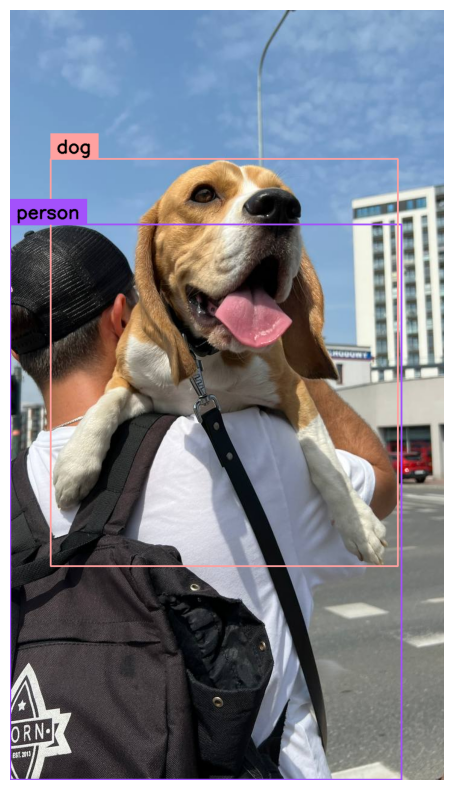

In [16]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Adjusting Confidence Level (신뢰 수준 조정)

프롬프트의 많은 클래스가 감지되지 않았습니다. 이는 추론의 기본 신뢰도 임계값이 `0.5`로 설정되어 있기 때문입니다. 이 값을 크게 낮춰 보겠습니다. COCO 데이터셋 외부의 클래스를 쿼리할 때 YOLO-World에서 반환되는 신뢰도가 현저히 낮다는 것을 관찰했습니다.

In [19]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results)

In [21]:
detections

Detections(xyxy=array([[    0.28851,      356.85,      649.82,      1279.9],
       [     67.294,      247.65,      643.15,      924.52],
       [     1.2042,      667.86,      443.91,        1280],
       [     338.44,      460.25,      468.83,      562.97],
       [      295.6,      288.05,      349.89,      323.12],
       [     387.21,      294.62,      483.92,      375.21]]), mask=None, confidence=array([    0.94848,     0.89629,     0.36671,    0.085839,     0.01352,   0.0099144]), class_id=array([0, 2, 1, 6, 3, 4]), tracker_id=None, data={'class_name': array(['person', 'dog', 'backpack', 'tongue', 'eye', 'nose'], dtype='<U8')})

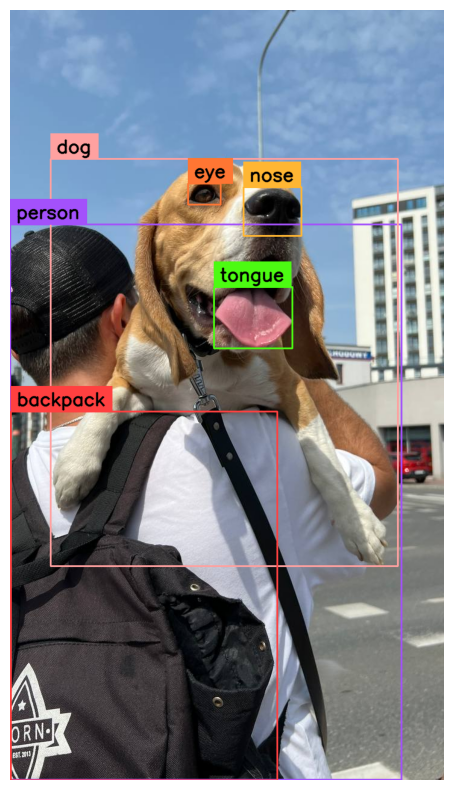

In [20]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## NMS(Non-Max Suppression)를 사용하여 이중 탐지 제거

중복을 제거하기 위해 NMS(Non-Max Suppression)를 사용합니다. NMS는 IoU(Intersection over Union) 메트릭을 사용하여 탐지가 겹치는 정도를 평가하고, 정의된 임계값을 초과하면 중복으로 처리합니다. 그런 다음 신뢰도가 가장 낮은 항목부터 중복 항목이 삭제됩니다. 값은 [0, 1] 범위 내에 있어야 합니다. 값이 작을수록 NMS가 더 제한적입니다.

In [22]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

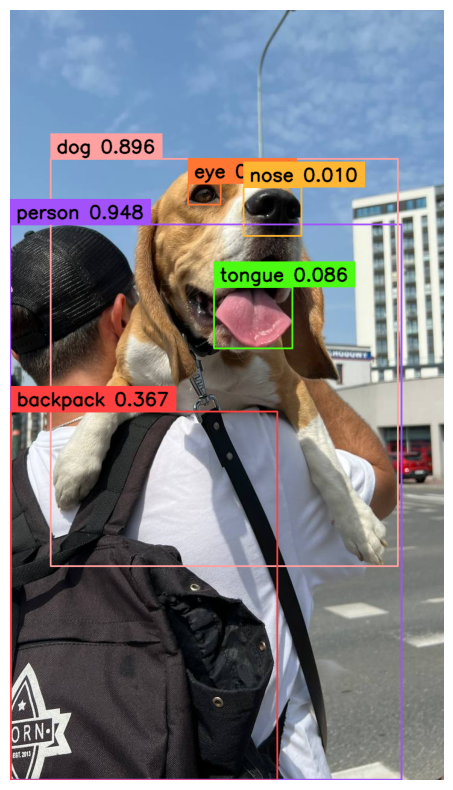

In [23]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Video Processing 비디오 프로세싱

이 `get_video_frames_generator` 사용하면 비디오 프레임을 쉽게 반복할 수 있습니다. 샘플 입력 파일에 대한 비디오 생성기를 만들고 첫 번째 프레임을 화면에 표시해 보겠습니다.

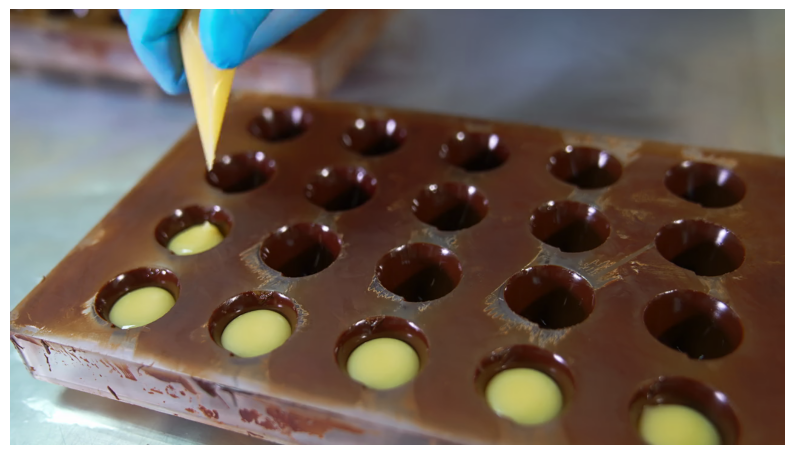

In [24]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

클래스 목록을 업데이트해 보겠습니다. 이번에는 yellow filling을 찾고 있습니다. 감지, 필터링 및 시각화를 수행하는 코드의 나머지 부분은 변경되지 않습니다.

In [28]:
classes = ["yellow filling"]
model.set_classes(classes)

In [31]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

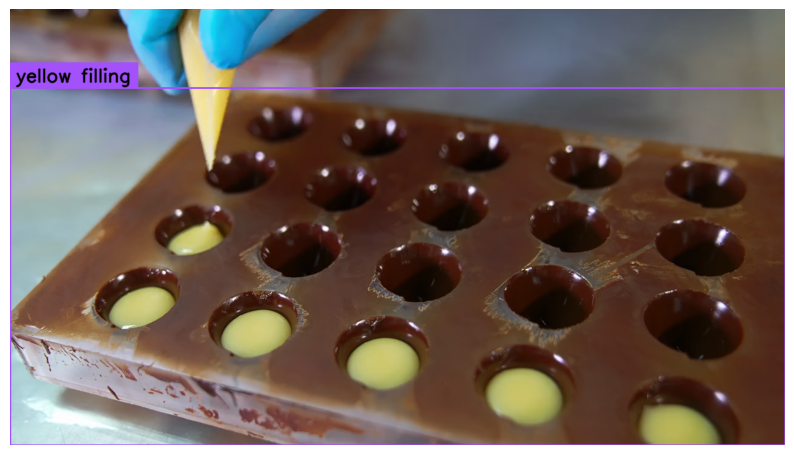

In [30]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## 영역별 Detectuions 필터링

프롬프트를 통해 채워진 모든 구멍을 찾을 수 있었지만 실수로 전체 고급 요소를 표시하기도 했습니다. 이 문제를 해결하기 위해 전체 비디오 프레임과 관련된 상대 영역을 기반으로 감지를 필터링합니다. 감지가 프레임 전체 영역의 10% 이상을 차지하면 삭제됩니다.

`VideoInfo.from_video_path` 사용하여 지속 시간, 해상도 또는 FPS와 같은 비디오에 대한 기본 정보를 배울 수 있습니다.

In [32]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=442)

프레임의 해상도를 알면 픽셀로 표현된 전체 면적을 쉽게 계산할 수 있습니다.

In [33]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

921600

반면에 `sv.Detections.area` 속성을 사용하면 각 개별 경계 상자의 면적을 학습할 수 있습니다.

In [37]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
detections.area

array([ 7.5409e+05])

이제 이 두 가지 정보를 결합하여 전체 프레임의 10%보다 큰 영역을 가진 탐지에 대한 필터링 조건을 구성할 수 있습니다.

In [38]:
(detections.area / frame_area) < 0.10

array([False])

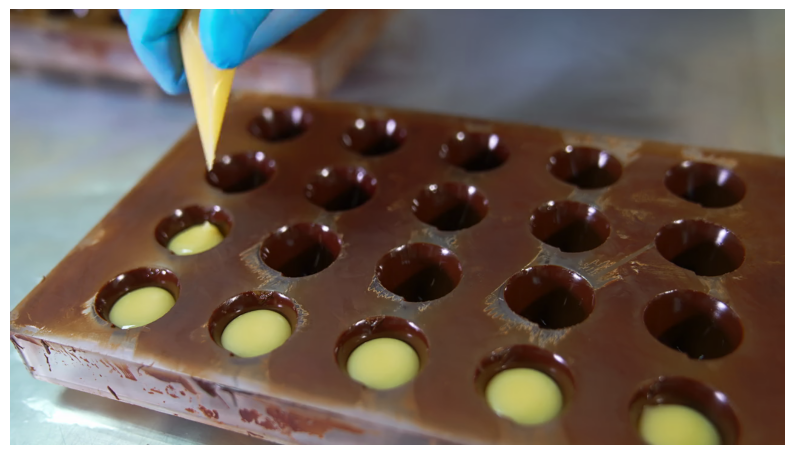

In [39]:
detections = detections[(detections.area / frame_area) < 0.10]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## 최종 결과

마지막으로 전체 비디오를 처리할 준비가 되었습니다. 이제 우리는 YOLO-World의 속도를 이해할 수 있습니다.

In [41]:
TARGET_VIDEO_PATH = f"{HOME}/yellow-filling-output.mp4"

In [42]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

width, height = video_info.resolution_wh
frame_area = width * height
frame_area

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = model.infer(frame, confidence=0.002)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
        detections = detections[(detections.area / frame_area) < 0.10]

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        sink.write_frame(annotated_frame)

100%|██████████| 442/442 [00:17<00:00, 24.94it/s]
